# Lets start by importing the required libraries

In [1]:
!pip install prophet

In [1]:
!pip install tpqoa

In [13]:
pip install mplfinance


Note: you may need to restart the kernel to use updated packages.


In [15]:
import mplfinance as mpf

In [2]:
import pandas as pd 
import datetime as dt 
import matplotlib.pyplot as plt 
import numpy as np 
from prophet import Prophet
from matplotlib.ticker import FuncFormatter
import tpqoa

c:\Users\bmsto\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Now lets initialize a connection to the Oanda API which is where we'll be getting historical EURUSD price data from.

In [4]:
api = tpqoa.tpqoa("../oanda.cfg")

### Now we can pull EURUSD data from the Oanda API

In [6]:
### Lets get a month worth of bid data on the Daily timeframe
december_2023 = api.get_history(instrument = "EUR_USD", start = "2023-12-01", end = "2023-12-31",
                granularity = "D", price = "B")

In [7]:
december_2023.head()

,o,h,l,c,volume,complete
time,,,,,,
2023-11-30 22:00:00,1.08840,1.09121,1.08280,1.08783,107289,True
2023-12-03 22:00:00,1.08764,1.08942,1.08033,1.08353,100649,True
2023-12-04 22:00:00,1.08346,1.08468,1.07773,1.07975,102469,True
2023-12-05 22:00:00,1.07908,1.08041,1.07579,1.07635,88864,True
2023-12-06 22:00:00,1.07636,1.08170,1.07543,1.07922,107483,True


## Now that we have our data, let's drop the columns we dont need.

In [25]:
#lets change the column names, so we can properly plot with mpf
plot_1 = december_2023.drop(columns=['volume', 'complete'])
plot_1.head()

,o,h,l,c
time,,,,
2023-11-30 22:00:00,1.08840,1.09121,1.08280,1.08783
2023-12-03 22:00:00,1.08764,1.08942,1.08033,1.08353
2023-12-04 22:00:00,1.08346,1.08468,1.07773,1.07975
2023-12-05 22:00:00,1.07908,1.08041,1.07579,1.07635
2023-12-06 22:00:00,1.07636,1.08170,1.07543,1.07922


## Now we can visualize our data.

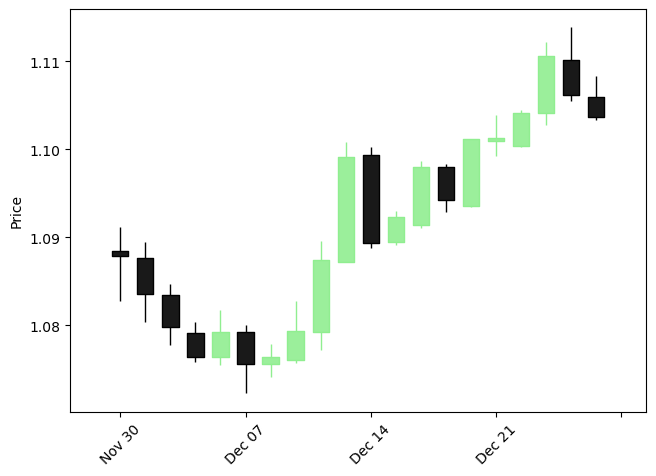

In [34]:

plot_1.columns = ['Open', 'High', 'Low', 'Close']

# Create a custom style
mc = mpf.make_marketcolors(up='lightgreen', down='black', inherit=True)
s  = mpf.make_mpf_style(marketcolors=mc)

mpf.plot(plot_1, type='candle', style=s)

plt.show()


## Now lets make our data interpretable for the phophet forecasting model.

In [43]:
decemeber_2023_prophet = december_2023.drop(columns=['o', 'h', 'l','volume','complete'])

In [44]:
decemeber_2023_prophet.head()

,c
time,
2023-11-30 22:00:00,1.08783
2023-12-03 22:00:00,1.08353
2023-12-04 22:00:00,1.07975
2023-12-05 22:00:00,1.07635
2023-12-06 22:00:00,1.07922


In [45]:
decemeber_2023_prophet = decemeber_2023_prophet.reset_index()


In [46]:
decemeber_2023_prophet.head()

,time,c
0,2023-11-30 22:00:00,1.08783
1,2023-12-03 22:00:00,1.08353
2,2023-12-04 22:00:00,1.07975
3,2023-12-05 22:00:00,1.07635
4,2023-12-06 22:00:00,1.07922


In [50]:
december_2023_prophet = decemeber_2023_prophet.rename(columns={'time': 'ds', 'c': 'y'})
december_2023_prophet.head()

,ds,y
0,2023-11-30 22:00:00,1.08783
1,2023-12-03 22:00:00,1.08353
2,2023-12-04 22:00:00,1.07975
3,2023-12-05 22:00:00,1.07635
4,2023-12-06 22:00:00,1.07922


## Now lets initial our prophet model to make some predictions for January 2024

In [36]:
model = Prophet()

In [51]:
model.fit(december_2023_prophet)

23:07:41 - cmdstanpy - INFO - Chain [1] start processing


23:07:42 - cmdstanpy - INFO - Chain [1] done processing


## Now lets create a place holder for our prediction in january.

In [53]:
january = model.make_future_dataframe(periods=31, freq="D")
january.head()

,ds
0,2023-11-30 22:00:00
1,2023-12-03 22:00:00
2,2023-12-04 22:00:00
3,2023-12-05 22:00:00
4,2023-12-06 22:00:00


## Now we're ready to predict the future ;)

In [54]:
january_2024_predictions = model.predict(january)
january_2024_predictions.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-11-30 22:00:00,0.605848,1.085463,1.090747,0.605848,0.605848,0.482360,0.482360,0.482360,0.482360,0.482360,0.482360,0.0,0.0,0.0,1.088208
1,2023-12-03 22:00:00,0.597931,1.079118,1.084230,0.597931,0.597931,0.483622,0.483622,0.483622,0.483622,0.483622,0.483622,0.0,0.0,0.0,1.081553
2,2023-12-04 22:00:00,0.595292,1.077229,1.082355,0.595292,0.595292,0.484473,0.484473,0.484473,0.484473,0.484473,0.484473,0.0,0.0,0.0,1.079765
3,2023-12-05 22:00:00,0.592653,1.075401,1.080571,0.592653,0.592653,0.485273,0.485273,0.485273,0.485273,0.485273,0.485273,0.0,0.0,0.0,1.077926
4,2023-12-06 22:00:00,0.592347,1.077285,1.082290,0.592347,0.592347,0.487440,0.487440,0.487440,0.487440,0.487440,0.487440,0.0,0.0,0.0,1.079787


## Now let's visualize our predictions

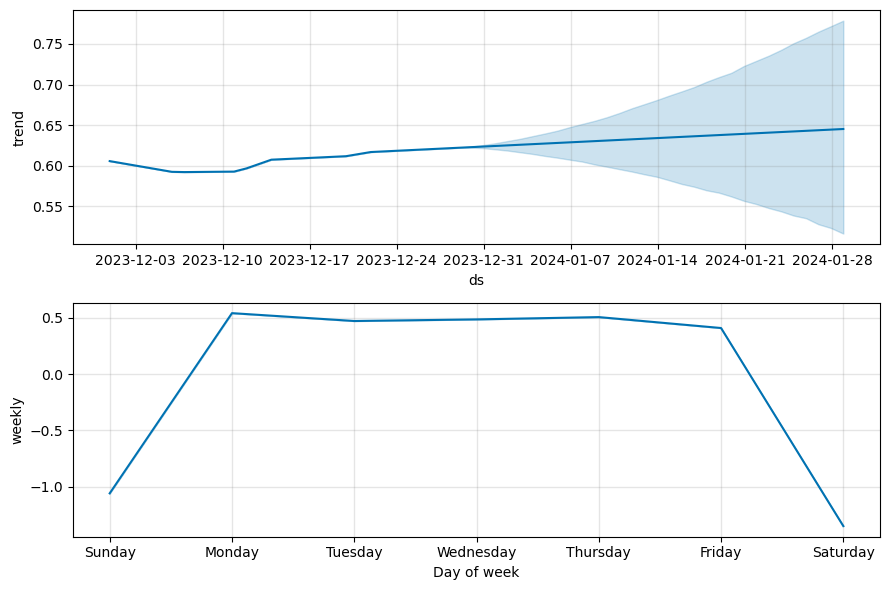

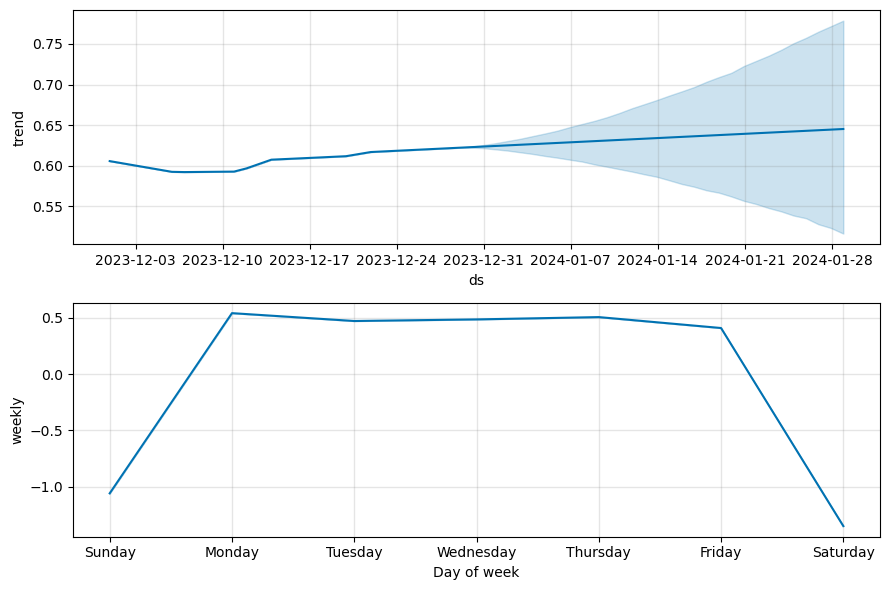

In [55]:
model.plot_components(january_2024_predictions)

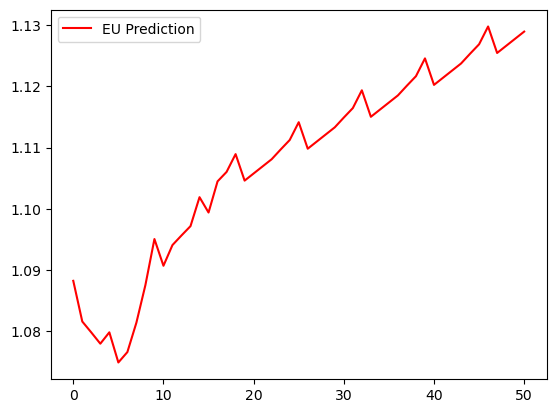

In [62]:
filtered_df = january_2024_predictions[january_2024_predictions['yhat'] > 1.00]

filtered_df['yhat'].plot(kind='line', color='red', label='EU Prediction')

plt.legend()
plt.show()


### From this data, we can denote that the Prophet model is forecasting an overall bullish month for January. Further analysis will be conducted to determine if the model has accurately forecasted EURUSD prices once January is finished. 